## BERT-F1 Considerations
* BERT-F1 had 3 different cases which we mention here
* BERT-F1 without rescaling with baseline (default)
* BERT-F1 with rescaling with baseline (option, recommended for more interpretable scores)
* BERT-F1 with different model type for English (default is `roberta-large`, we used `bert-base-multilingual-cased`)
* Scores can be found [here](https://drive.google.com/drive/folders/1kVxEZKM8nx9MXzoJ-7-cTn9MldhRHTbD?usp=sharing)
* Note: These are old scores, the final scores that are also presented in the thesis can be found in `final_results.csv` in the root directory of this repository. 

In [1]:
from scripts.util import get_env_variables
from os.path import join
results_folder = get_env_variables('RESULTS')
bert_no_rescale = join(results_folder, 'bert_f1_no_rescale')
bert_rescale = join(results_folder, 'bert_f1')

In [2]:
import pandas as pd
df1 = pd.read_csv(join(bert_no_rescale, 'ep-deepl.csv'))
df2 = pd.read_csv(join(bert_rescale, 'ep-deepl.csv'))


df1['dataset'] = 'ep'
df2['dataset'] = 'ep'
df1['translator'] = 'deepl'
df2['translator'] = 'deepl'

label_split = df1['Label'].str.split('-', expand=True)
df1['src_lang'] = label_split[0]
df1['tgt_lang'] = label_split[1]

label_split = df2['Label'].str.split('-', expand=True)
df2['src_lang'] = label_split[0]
df2['tgt_lang'] = label_split[1]

Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : BERT-F1
Pearson correlation: 0.72 (p = 3.8e-19)
Spearman correlation: 0.92 (p = 1.0e-45)


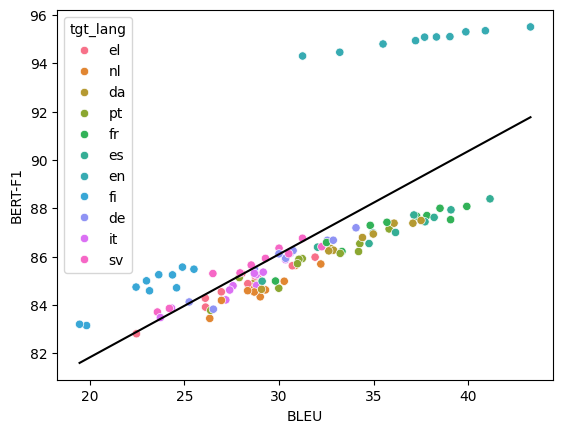

Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : BERT-F1
Pearson correlation: 0.07 (p = 4.6e-01)
Spearman correlation: 0.30 (p = 1.3e-03)


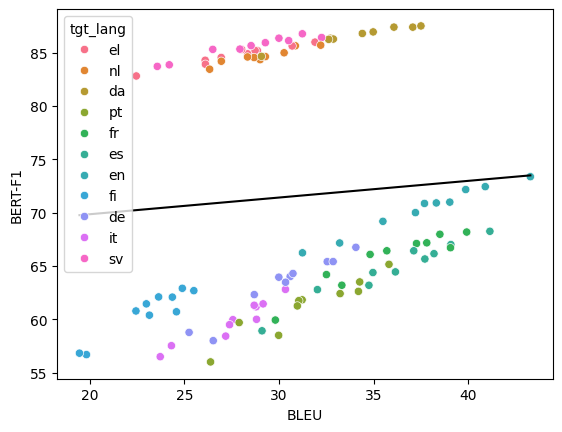

In [3]:
from scripts.presentation import correlations, linear_regression
for df in [df1, df2]:
    for d in ['ep']:
        for t in ['deepl']:
            config1 = {
                'datasets': [d],
                'translators': [t],
                'src_lang': None,
                'tgt_lang': None,
                'metric': 'BLEU'

            }
            config2 = {
                'datasets': [d],
                'translators': [t],
                'src_lang': None,
                'tgt_lang': None,
                'metric': 'BERT-F1'
            }
            correlations(df, config1, config2, show=True)
            data, model = linear_regression(df, config1, config2, x_label='BLEU', y_label='BERT-F1', plot=True, color_by='tgt_lang')


* If we apply rescaling on everything, we actually apply rescaling only on: `de`, `en`, `es`, `fi`, `fr`, `it`, `pt`
    * This is why linear regression shows a big gap between those two target languages; the one that were rescaled are lower
    * `el`, `nl`, `da` and `sv` were not rescaled
* If we do not apply rescaling, we use model `roberta-large` for English and `bert-base-multilingual-cased` for all other languages
    * This is why linear regression shows a gap between English and other target languages, a different model was used.

* Thus, we decide to use `bert-base-multilingual-cased` for all languages without applying rescaling


## Creating Central Scores File
* We scored COMET and BERT-F1 scores in different Jupyter Notebooks with different splits (not all at once)
* Hence we create one file CSV file containing all 480 scores by concatenating all CSV files
* We have a guarantee that BERT-F1 and COMET scores were obtained from the exact same translations because we merge (inner join) on BLEU and chrF scores as well.
* All scores can be found individually [here](https://drive.google.com/drive/folders/1p1iLFtg1zi4-Aw5OcTivDtZ-ZqUFVOqQ?usp=sharing)
* The `RESULTS` environment variable refers to the file path where the CSV files are stored 

In [4]:
from scripts.util import get_env_variables
from os.path import join
import os
import pandas as pd
from scripts.presentation import parse_results_from_file
results_folder = get_env_variables('RESULTS')
results = join(results_folder, 'true_final_results')
df_bert = parse_results_from_file(join(results, 'bert-f1.csv'))
df_comet = parse_results_from_file(join(results, 'comet.csv'))

len(df_bert), len(df_comet)

(480, 480)

* We have 480 scores for BERT-F1 and COMET

In [5]:
df_bert.head(3)

,BLEU,chrF,BERT-F1,dataset,translator,src_lang,tgt_lang
0,54.799530,75.295543,93.870700,flores,deepl,da,en
1,33.634741,60.229124,89.559616,flores,deepl,fr,pt
2,28.786491,57.433125,86.359790,flores,gpt,nl,de


In [6]:
df_comet.head(3)

,BLEU,chrF,COMET,dataset,translator,src_lang,tgt_lang
0,54.799530,75.295543,91.044375,flores,deepl,da,en
1,33.634741,60.229124,88.003590,flores,deepl,fr,pt
2,28.786491,57.433125,86.766763,flores,gpt,nl,de


In [7]:
df = pd.merge(df_bert, df_comet, on=[
              'dataset', 'translator', 'src_lang', 'tgt_lang', 'BLEU', 'chrF'])
# Proves that BERT-F1 and COMET were computed on the same exact translations, otherwise impossible to have identical BLEU and chrF
df.to_csv('final_results.csv', index=False)
len(df)

480